# Sales Forecasting with Time Series Analysis on AdventureWorks Data Warehouse

## Objective
Predict future sales quantities (daily, monthly, quarterly) to optimize inventory, staffing, and marketing strategies.

***Data Sources (AdventureWorks Tables)***

You can extract relevant data from:
1. FactInternetSales / FactResellerSales – Contains sales transactions with timestamps.

- Key columns: OrderDate, SalesAmount, ProductKey, CustomerKey, OrderQuantity

2. DimDate – Provides calendar hierarchies (day, month, year, fiscal periods).

- Key columns: DateKey, FullDateAlternateKey, Month, CalendarYear, FiscalYear

3. DimProduct – Product details for category-level forecasting.

- Key columns: ProductKey, ProductSubcategoryKey, ProductCategory

4. DimGeography / DimCustomer – Regional sales trends.

- Key columns: GeographyKey, Country, Region, City

### Approach
***1. Data Preparation***

- ***Aggregate sales data*** by time period (daily, weekly, monthly).

```sql
-- Example SQL query to get monthly sales
 SELECT 
    d.CalendarYear,
    d.MonthNumberOfYear AS Month,
    SUM(fis.SalesAmount) AS TotalSales,
    COUNT(DISTINCT fis.SalesOrderNumber) AS OrderCount
FROM FactInternetSales fis
JOIN DimDate d ON fis.OrderDateKey = d.DateKey
GROUP BY d.CalendarYear, d.MonthNumberOfYear
ORDER BY d.CalendarYear, d.MonthNumberOfYear;
```

- ***Handle missing dates*** (if sales were zero on some days).
- ***Decompose time series*** into trend, seasonality, and residuals.

***2. Feature Engineering***
- ***Lag features*** (previous month’s sales, rolling averages).
- ***Seasonal indicators*** (holidays, fiscal year-end effects).
- ***External factors*** (if available, like promotions, economic indicators).

***3. Model Selection***
|Algorithm	|Use Case	|Pros	|Cons|
|---|---|---|---| 
|ARIMA	|Best for stationary data with clear trends/seasonality	|Works well with small datasets	|Requires manual parameter tuning|
|SARIMA	|Handles seasonal patterns better than ARIMA	|Explicitly models seasonality	Complex parameter selection|
|Prophet (Facebook)	|Automatic handling of holidays & trends	|Robust to missing data	Less interpretable than ARIMA|
|LSTM (Deep Learning)	|Best for complex, long-term dependencies	|Learns nonlinear patterns	|Requires large data & tuning|

***4. Evaluation Metrics***
- ***MAE (Mean Absolute Error)- *** – Easy to interpret (average error in $).
- ***RMSE (Root Mean Squared Error)- *** – Penalizes large errors more.
- ***MAPE (Mean Absolute Percentage Error)- *** – % error relative to actual sales.

***5. Implementation Steps***
- ***Train-Test Split*** (e.g., use 2011-2013 for training, 2014 for testing).
- ***Fit models*** (ARIMA, Prophet, etc.) and compare performance.
- ***Forecast future sales*** (next 6-12 months).
- ***Visualize results*** (actual vs. predicted with confidence intervals).

***Example Python Code (Using Prophet)***
```python

import pandas as pd
from prophet import Prophet

# Load aggregated monthly sales data
df = pd.read_csv("monthly_sales.csv")
df = df.rename(columns={"OrderDate": "ds", "TotalSales": "y"})

# Fit Prophet model (automatically detects seasonality)
model = Prophet(yearly_seasonality=True, weekly_seasonality=False)
model.fit(df)

# Forecast next 12 months
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Plot results
fig = model.plot(forecast)

```
## Business Applications
***Inventory Management*** – Stock products before predicted high-demand periods.

***Marketing Budgeting*** – Allocate promotions when sales are forecasted to dip.

***Staff Planning*** – Adjust workforce based on expected sales volume.

 

# Advanced Sales Forecasting: ARIMA Tuning & LSTM Implementation
Let's dive deeper into both ARIMA tuning and LSTM implementation for the AdventureWorks sales forecasting problem.

## Part 1: ARIMA Model Tuning

***1. Understanding ARIMA Parameters***

ARIMA has three key parameters:
- ***p (AR - AutoRegressive)***: Number of lag observations in the model
- ***d (I - Integrated)***: Degree of differencing needed to make the series stationary
- ***q (MA - Moving Average)***: Size of the moving average window

***2. Step-by-Step Implementation***

***Data Preparation***
```python
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv('monthly_sales.csv', parse_dates=['OrderDate'])
df = df.set_index('OrderDate').asfreq('MS')  # Monthly Start frequency

# Check stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    
test_stationarity(df['TotalSales'])

# If not stationary, apply differencing
df['SalesDiff'] = df['TotalSales'].diff().dropna()
test_stationarity(df['SalesDiff']) 
```

***Finding Optimal ARIMA Parameters***

```python
from pmdarima import auto_arima

# Auto ARIMA to find best parameters
model = auto_arima(df['TotalSales'], seasonal=True, m=12,
                   trace=True, suppress_warnings=True)
print(model.summary())

# Typical output might suggest SARIMAX(1,1,1)(1,1,1)[12] 
```

***Manual Parameter Tuning with ACF/PACF***
    
```python
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF to identify p and q
plot_acf(df['SalesDiff'].dropna(), lags=20)
plot_pacf(df['SalesDiff'].dropna(), lags=20)
plt.show()
```

***Model Training & Validation***

```python
# Split data
train = df[:'2013-12-31']
test = df['2014-01-31':]

# Fit ARIMA model
model = ARIMA(train['TotalSales'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=len(test))
```

***Evaluating Results***
    
```python
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['TotalSales'], forecast)
print(f'MAE: {mae:.2f}')

# Plot results
plt.plot(train.index, train['TotalSales'], label='Train')
plt.plot(test.index, test['TotalSales'], label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()
```

## Part 2: LSTM Implementation
***1. Why LSTM for Sales Forecasting?***

LSTMs (Long Short-Term Memory networks) are ideal for:
- Capturing complex seasonal patterns
- Learning from long sequences of data
- Handling multiple input features

***2. Step-by-Step Implementation***
***Data Preparation for LSTM***
```python
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['TotalSales']])

# Create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 12  # Using 12 months to predict next month
X, y = create_sequences(scaled_data, n_steps)

# Split into train/test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
```

***Building the LSTM Model***

```python
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_test, y_test), verbose=0)

# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
```

***Making Predictions***
```python
# Forecast on test data
y_pred = model.predict(X_test)

# Inverse transform to original scale
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'LSTM MAE: {mae:.2f}')

# Plot predictions
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()
```

***Multi-step Forecasting***
``` python
# Function for recursive multi-step forecasting
def forecast_lstm(model, initial_sequence, n_steps):
    current_seq = initial_sequence
    forecasts = []
    for _ in range(n_steps):
        next_pred = model.predict(current_seq.reshape(1, n_steps, 1))
        forecasts.append(next_pred[0,0])
        current_seq = np.append(current_seq[1:], next_pred)
    return scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# Get last sequence from training data
last_sequence = scaled_data[-n_steps:]

# Forecast next 12 months
future_forecast = forecast_lstm(model, last_sequence, 12)
```

***Comparison: ARIMA vs LSTM***
|Aspect	|ARIMA	|LSTM|
|---|---|---|
|Data Needs	|Works well with small datasets	|Requires large datasets|
|Seasonality	|Manual handling (SARIMA)	|Automatically learns patterns|
|Features	|Single time series	|Can incorporate multiple features|
|Training Time	|Fast	|Slow (needs GPU for large data)|
|Interpretability	|Highly interpretable	|Black box model|

***Which to Choose?***
- ***Use ARIMA*** if:
    - Your dataset is small/medium-sized
    - You need explainable results
    - Clear seasonality exists

- ***Use LSTM*** if:
    - You have large amounts of data
    - You need to incorporate multiple features (promotions, weather, etc.)
    -Complex patterns exist that ARIMA can't capture

# Complete Sales Forecasting Notebook for AdventureWorks

Below is a comprehensive Jupyter notebook that implements both ARIMA and LSTM models for sales forecasting using data directly from the AdventureWorks data warehouse.

# AdventureWorks Sales Forecasting
## ARIMA vs LSTM Implementation
### This notebook demonstrates time series forecasting on AdventureWorks sales data using:
1. ARIMA with parameter tuning
2. LSTM neural networks
 
Data is extracted directly from the AdventureWorksDW database

In [ ]:
sudo apt update
sudo apt install unixodbc
ldconfig -p | grep libodbc
pip install statsmodels
pip install pmdarima
pip install tensorflow
pip install keras




In [1]:
# Import libraries
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')


## 1. Data Extraction from AdventureWorksDW

In [27]:
cnxn = pyodbc.connect("Driver={ODBC Driver 17 for SQL Server};Server=tcp:DESKTOP-GQ7PL6J,1433;Database=AdventureWorksLT2022;Uid=sa;Pwd=admin1212;Connection Timeout=60;")
cursor = cnxn.cursor()
# select 10 rows from SQL table to insert in dataframe.
query = "select * from [SalesLT].[Address];"
df = pd.read_sql(query, cnxn)
print(df.head(5))

   AddressID         AddressLine1 AddressLine2      City StateProvince  \
0          9    8713 Yosemite Ct.         None   Bothell    Washington   
1         11  1318 Lasalle Street         None   Bothell    Washington   
2         25     9178 Jumping St.         None    Dallas         Texas   
3         28     9228 Via Del Sol         None   Phoenix       Arizona   
4         32    26910 Indela Road         None  Montreal        Quebec   

   CountryRegion PostalCode                               rowguid ModifiedDate  
0  United States      98011  268AF621-76D7-4C78-9441-144FD139821A   2006-07-01  
1  United States      98011  981B3303-ACA2-49C7-9A96-FB670785B269   2007-04-01  
2  United States      75201  C8DF3BD9-48F0-4654-A8DD-14A67A84D3C6   2006-09-01  
3  United States      85004  12AE5EE1-FC3E-468B-9B92-3B970B169774   2005-09-01  
4         Canada    H1Y 2H5  84A95F62-3AE8-4E7E-BBD5-5A6F00CD982D   2006-08-01  


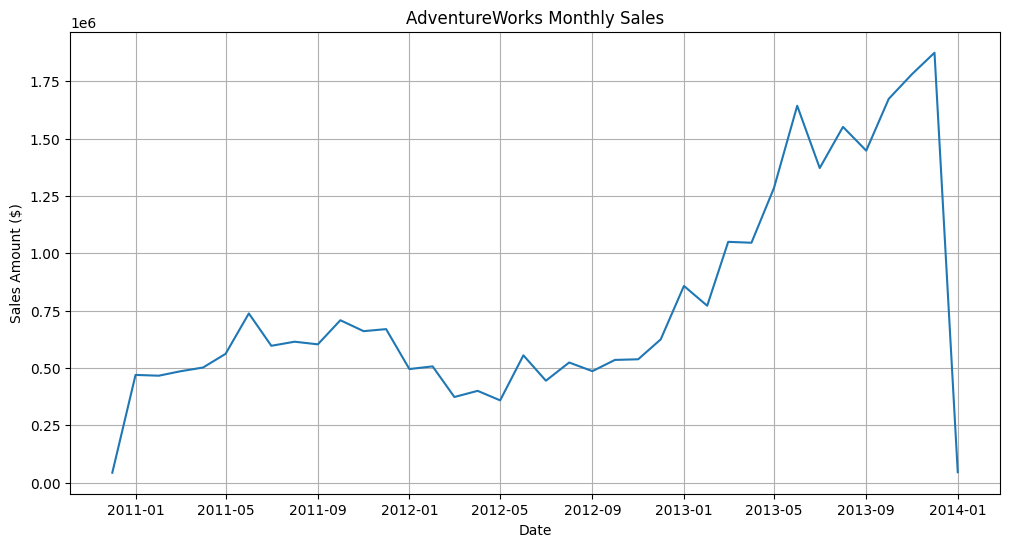

In [7]:
# Database connection function
def get_aw_data():
    conn = pyodbc.connect("Driver={ODBC Driver 17 for SQL Server};Server=tcp:DESKTOP-GQ7PL6J,1433;Database=AdventureWorksDW2022;Uid=sa;Pwd=admin1212;Connection Timeout=60;")
    # conn = pyodbc.connect(
    #     'Driver={ODBC Driver 17 for SQL Server};'
    #     'Server=tcp:DESKTOP-GQ7PL6J,1433;'
    #     'Database=AdventureWorksDW2022;'
    #     'UID=sa;'
    #     'PWD=admin1212'
    #     'Encrypt=yes;'
    #     'TrustServerCertificate=yes;'
    #     'Connection Timeout=60;'
    #)
     
    query = """
    SELECT 
        d.FullDateAlternateKey AS OrderDate,
        SUM(fis.SalesAmount) AS TotalSales,
        COUNT(DISTINCT fis.SalesOrderNumber) AS OrderCount
    FROM FactInternetSales fis
    JOIN DimDate d ON fis.OrderDateKey = d.DateKey
    GROUP BY d.FullDateAlternateKey
    ORDER BY d.FullDateAlternateKey
    """
    
    df = pd.read_sql(query, conn)
    conn.close()
    return df

# Load data
sales_df = get_aw_data()
sales_df['OrderDate'] = pd.to_datetime(sales_df['OrderDate'])
sales_df.set_index('OrderDate', inplace=True)
sales_df = sales_df.asfreq('D').fillna(0)  # Fill missing days with 0 sales

# Resample to monthly
monthly_sales = sales_df['TotalSales'].resample('MS').sum()

# Plot original data
plt.figure(figsize=(12,6))
plt.plot(monthly_sales)
plt.title('AdventureWorks Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount ($)')
plt.grid()
plt.show()


## 2. ARIMA Implementation

In [8]:
# Stationarity check
def test_stationarity(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

test_stationarity(monthly_sales)


ADF Statistic: -2.1406911952998136
p-value: 0.2284702397925491
Critical Values:
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224


In [9]:

# %%
# Differencing to make stationary
monthly_sales_diff = monthly_sales.diff().dropna()
test_stationarity(monthly_sales_diff)

# %%
# Auto ARIMA to find best parameters
stepwise_model = auto_arima(monthly_sales, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(stepwise_model.summary())


ADF Statistic: -1.9694975910408252
p-value: 0.30010536031120993
Critical Values:
	1%: -3.6996079738860943
	5%: -2.9764303469999494
	10%: -2.627601001371742
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=726.422, Time=0.78 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=726.983, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=725.660, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=726.548, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=720.027, Time=0.64 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=718.139, Time=0.30 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=720.009, Time=1.28 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=721.981, Time=1.79 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=719.559, Time=0.54 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=723.034, Time=0.75 sec
 ARIMA(1,1,2)(1,1

In [10]:

# %%
# Manual ARIMA model
# Split data (last 12 months for testing)
train_size = int(len(monthly_sales) * 0.8)
train, test = monthly_sales[:train_size], monthly_sales[train_size:]

# Fit model
model = ARIMA(train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.summary())


                                    SARIMAX Results                                     
Dep. Variable:                       TotalSales   No. Observations:                   30
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -224.688
Date:                          Mon, 12 May 2025   AIC                            459.376
Time:                                  14:28:07   BIC                            463.542
Sample:                              12-01-2010   HQIC                           459.790
                                   - 05-01-2013                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8405      1.610     -0.522      0.602      -3.996       2.315
ma.L1          0.5535      2.396      0.231      0.

In [19]:

# %%
# Forecasting
forecast = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluation
mae_arima = mean_absolute_error(test, forecast_mean)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_mean))


print(f'MAE: {mae_arima:.2f}')
print(f'RMSE: {rmse_arima:.2f}')


MAE: 402428.13
RMSE: 522066.86


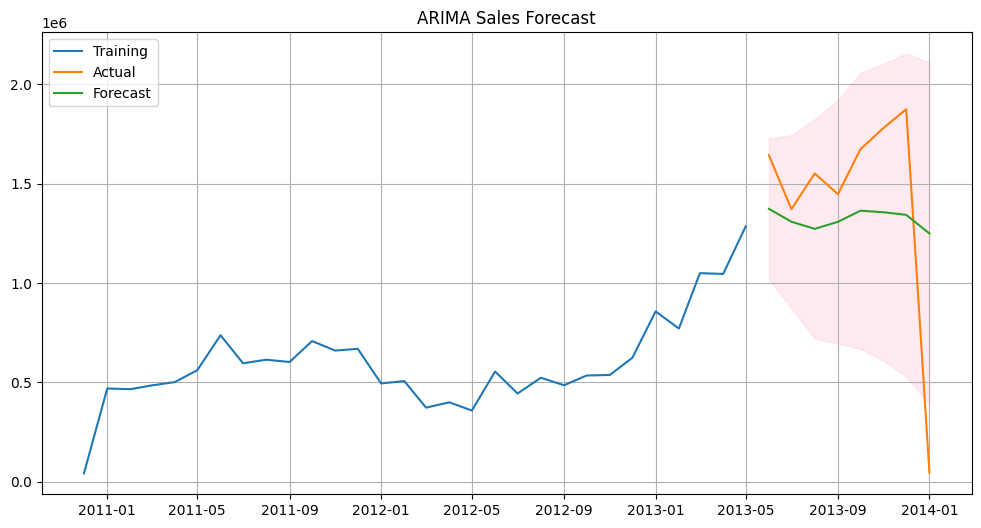

In [20]:

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_mean, label='Forecast')
plt.fill_between(test.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Sales Forecast')
plt.legend()
plt.grid()
plt.show()


In [13]:

# %% [markdown]
# ## 3. LSTM Implementation

# %%
# Prepare data for LSTM
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(monthly_sales.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 12
X, y = create_sequences(scaled_sales, n_steps)

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# %%
# Build LSTM model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train model
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    verbose=1)



Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1814 - val_loss: 0.6457
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.1717 - val_loss: 0.6212
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.1636 - val_loss: 0.5973
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 0.1556 - val_loss: 0.5737
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.1477 - val_loss: 0.5501
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.1401 - val_loss: 0.5258
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.1329 - val_loss: 0.5016
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.1261 - val_loss: 0.4782
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.1192 - val_loss: 0.4557
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.1120 - val_loss: 0.4319
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.1045 - val_loss: 0.4068
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.0966

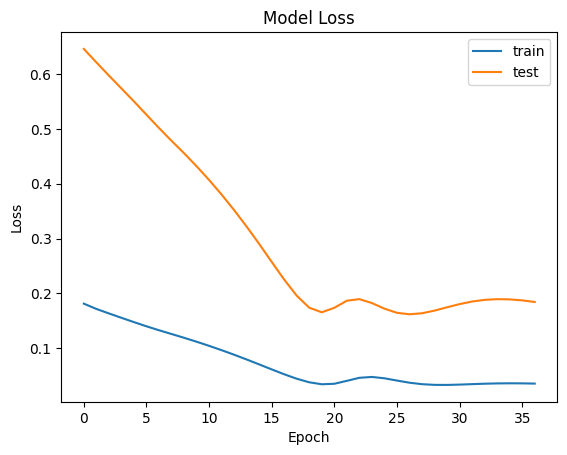

In [14]:
# %%
# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [21]:

# %%
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Evaluation
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'LSTM MAE: {mae_lstm:.2f}')
print(f'LSTM RMSE: {rmse_lstm:.2f}')




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
LSTM MAE: 763164.64
LSTM RMSE: 786244.74


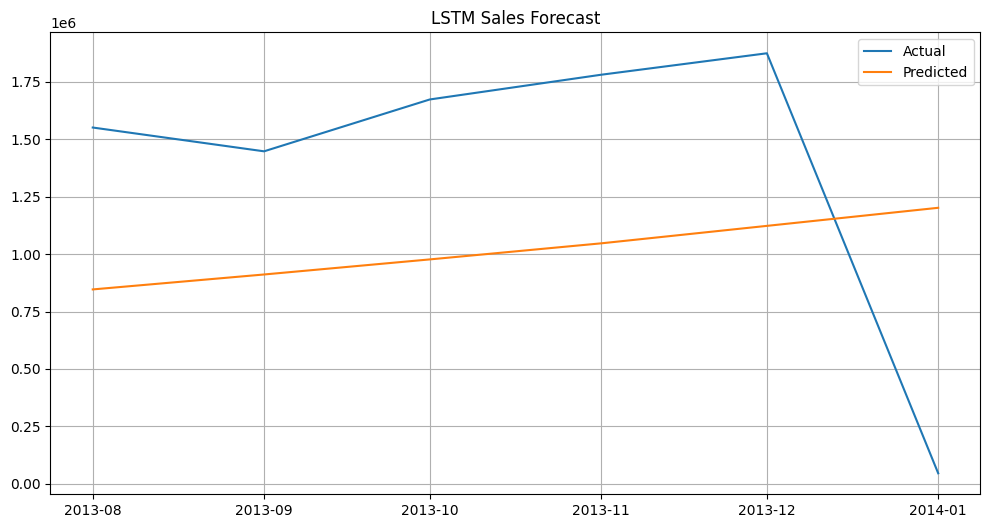

In [16]:

# %%
# Plot predictions
plt.figure(figsize=(12,6))
plt.plot(monthly_sales.index[n_steps+train_size:], y_test_inv, label='Actual')
plt.plot(monthly_sales.index[n_steps+train_size:], y_pred_inv, label='Predicted')
plt.title('LSTM Sales Forecast')
plt.legend()
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


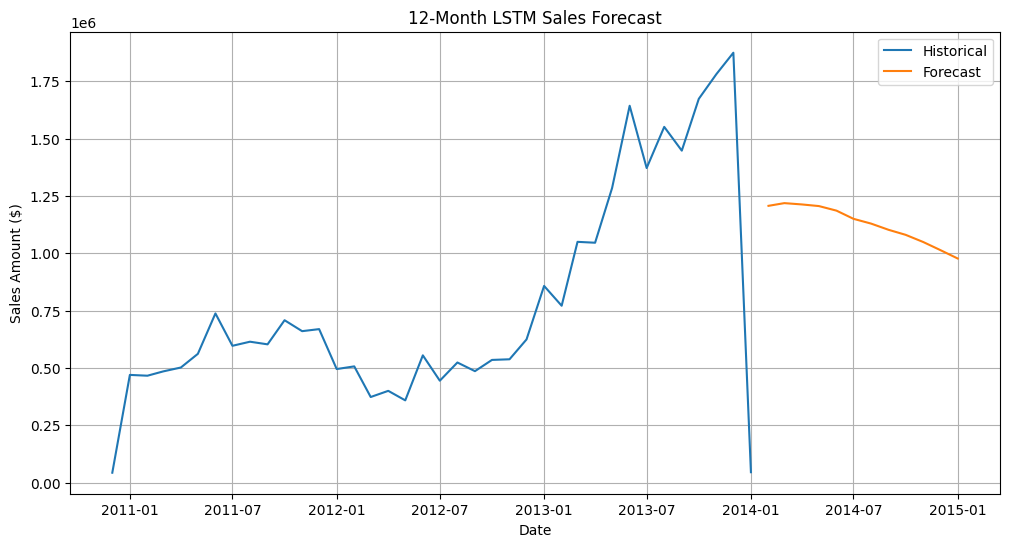

In [22]:

# %%
# Multi-step forecasting function
def forecast_lstm(model, initial_sequence, n_steps, scaler):
    current_seq = initial_sequence
    forecasts = []
    for _ in range(n_steps):
        next_pred = model.predict(current_seq.reshape(1, n_steps, 1))
        forecasts.append(next_pred[0,0])
        current_seq = np.append(current_seq[1:], next_pred)
    return scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# Get last sequence
last_sequence = scaled_sales[-n_steps:]

# Forecast next 12 months
future_forecast = forecast_lstm(model, last_sequence, 12, scaler)

# Create future dates
last_date = monthly_sales.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Plot final forecast
plt.figure(figsize=(12,6))
plt.plot(monthly_sales.index, monthly_sales, label='Historical')
plt.plot(future_dates, future_forecast, label='Forecast')
plt.title('12-Month LSTM Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Amount ($)')
plt.legend()
plt.grid()
plt.show()


In [23]:

# %% [markdown]
# ## 4. Model Comparison

# %%
# Compare performance
comparison = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM'],
    'MAE': [mae_arima, mae_lstm],
    'RMSE': [rmse_arima, rmse_lstm]
})

print(comparison)



   Model            MAE           RMSE
0  ARIMA  402428.131896  522066.861538
1   LSTM  763164.642083  786244.738301


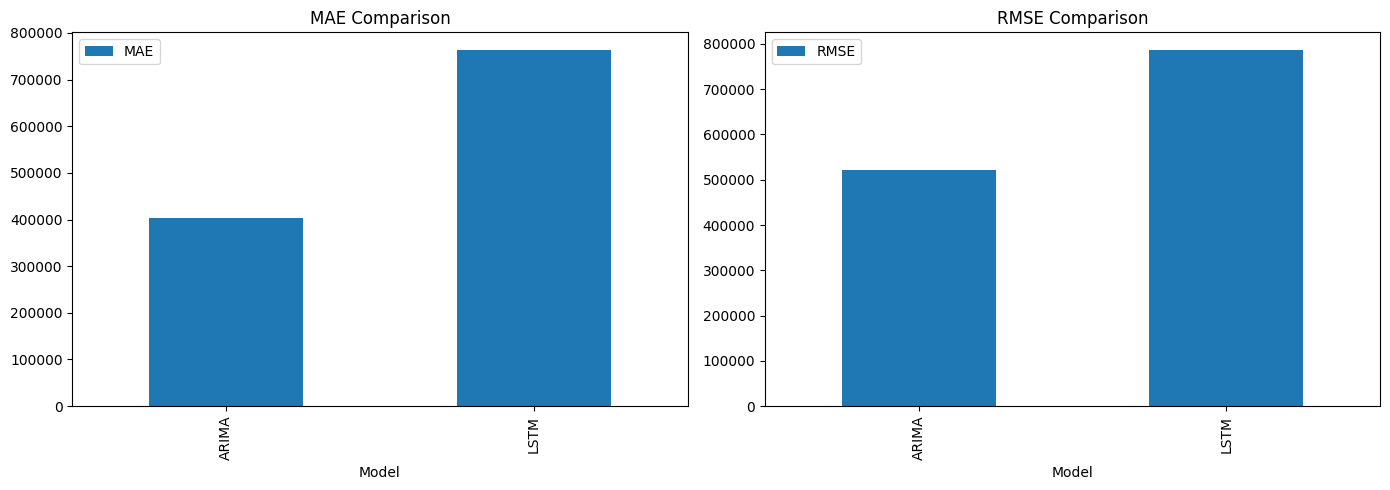

In [24]:
# Plot comparison
fig, ax = plt.subplots(1, 2, figsize=(14,5))
comparison.plot(x='Model', y='MAE', kind='bar', ax=ax[0], title='MAE Comparison')
comparison.plot(x='Model', y='RMSE', kind='bar', ax=ax[1], title='RMSE Comparison')
plt.tight_layout()
plt.show()